In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy import stats

from tqdm import tqdm

import ipywidgets as widgets
from src.models import ContextSpaceNet, OldSpaceNet, RecurrentSpaceNet
from src.utils import ratemap_collage, SimpleDatasetMaker

plt.style.use("project_style.mplstyle")
%matplotlib inline

### Loss normal vs context

In [20]:
loss_dict = {}

In [25]:
train_steps = 10000
n_out = 100 # no. of spatial representations
bs = 512 # batch size

n_in = 3 # 2 position + 1 context
context_model = ContextSpaceNet(n_in, n_out, scale=0.1, lam=0.001)
optimizer = torch.optim.Adam(context_model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)
    c = torch.tensor(np.random.uniform(-5, 5, bs), dtype = torch.float32)
    inputs = torch.cat((r, c[:,None]), dim = -1)
    loss = context_model.train_step(x = inputs, y = inputs, optimizer = optimizer)

    loss_history.append(loss)
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000154: 100%|██████████| 10000/10000 [03:05<00:00, 53.81it/s]


In [26]:
loss_dict['with context'] = loss_history

In [7]:
n_in = 2 # 2 position inputs

model = OldSpaceNet(n_in, n_out)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r = torch.tensor(np.random.uniform(-1, 1, (bs, 2)), dtype= torch.float32)
    loss = model.train_step(x = r, y = r, optimizer = optimizer)

    loss_history.append(loss)
    if i % 10 == 0:
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000081: 100%|██████████| 10000/10000 [00:43<00:00, 227.79it/s]


In [8]:
loss_dict['without'] = loss_history

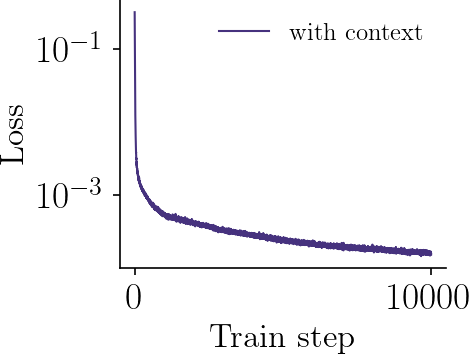

In [27]:
for key, value in loss_dict.items():
    plt.semilogy(np.arange(len(loss_history)), value, label=key)
plt.ylabel('Loss')
plt.xlabel('Train step')
plt.legend(loc='upper right', prop={'size': 12})
plt.savefig('context_vs_normal_loss')
plt.show()

### Representations

Generate ratemaps...

In [11]:
# Evaluate on 32x32 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)
p = model.spatial_representation(u).detach().numpy()
mask = np.mean(p, axis = 0) > 0
ratemaps = p.T[mask].reshape(-1, 32, 32)

... and plot them

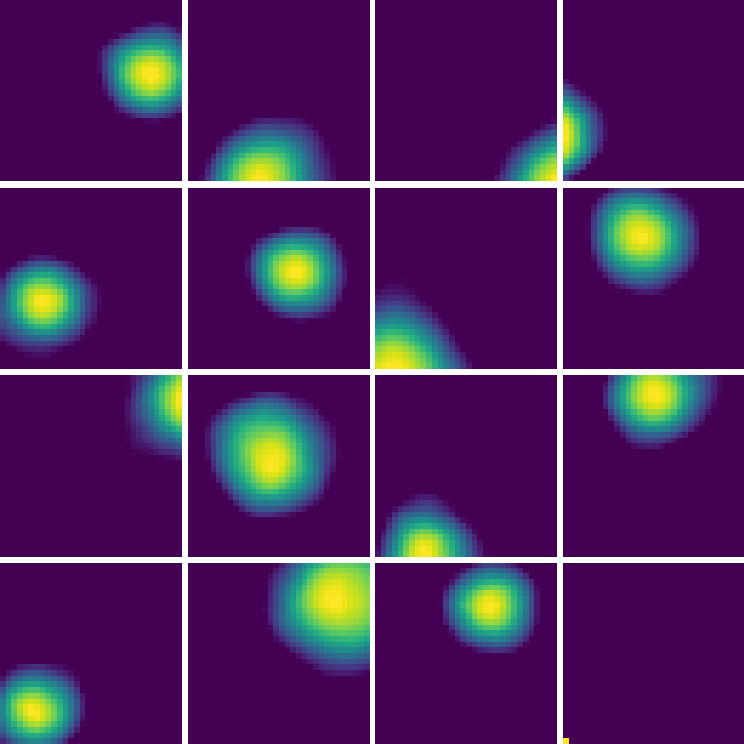

In [13]:
fig, ax = ratemap_collage(ratemaps[:25])
fig.savefig('ratemaps_normal')

Same for the context model

In [31]:
# Evaluate on 32x32 grid
n = 32
x = np.linspace(-1, 1, n)
y = x.copy()
xx, yy = np.meshgrid(x,y)
u = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis = -1), dtype= torch.float32)

ratemaps = []
for c in np.linspace(-5, 5, 10):

    context = c * torch.tensor(np.ones(len(u)), dtype = torch.float32)
    inputs = torch.cat((u, context[...,None]), dim=-1)

    p = context_model.spatial_representation(inputs).detach().numpy().T

    ratemaps.append(p.reshape(-1, 32, 32))

ratemaps = np.array(ratemaps)

In [32]:
ratemaps.shape

(10, 100, 32, 32)

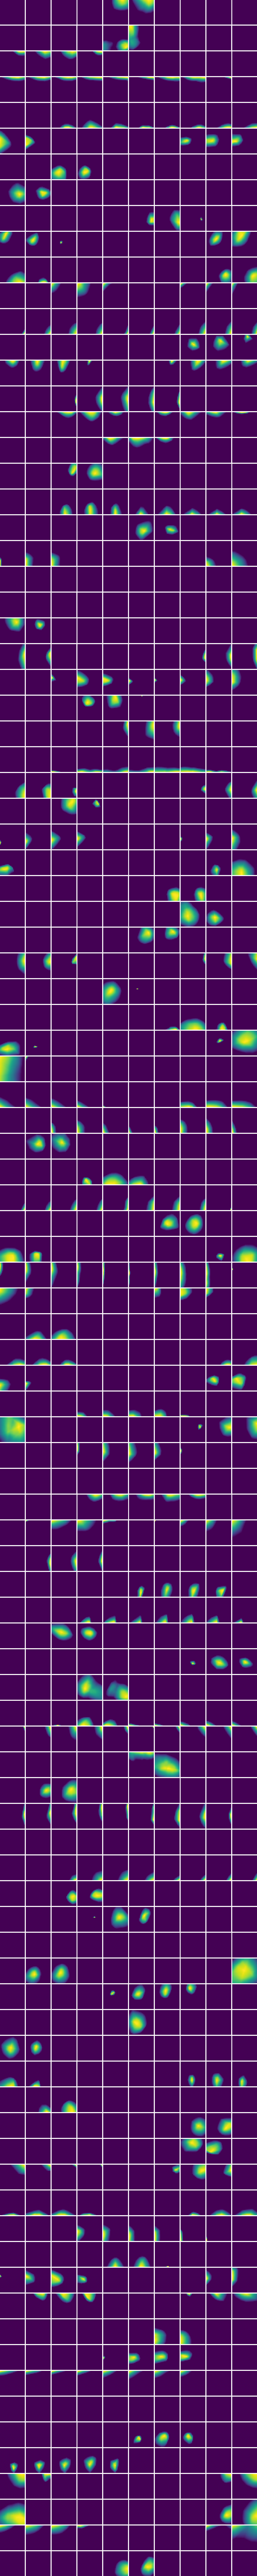

In [33]:
# Select cells
cells = np.arange(100)

fig, axs = plt.subplots(cells.shape[0], ratemaps.shape[0], figsize=(ratemaps.shape[0], cells.shape[0]))
for index in np.ndindex((cells.shape[0], ratemaps.shape[0])):

    axs[index].imshow(ratemaps[index[1], cells[index[0]]].T, origin="lower")
    axs[index].axis("off")

# fig.savefig('ratemaps_context')

### RNN short trajectories

In [26]:
train_steps = 50000 # No. of training steps
n_in = 2            # Cartesian coordinates, no context
n_out = 500         # No. of spatial representations
timesteps = 10      # Length of trajectory
bs = 32             # Batch size

# Create model
model = RecurrentSpaceNet(n_in, n_out, scale=0.3, corr_across_space=True)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Create dataset

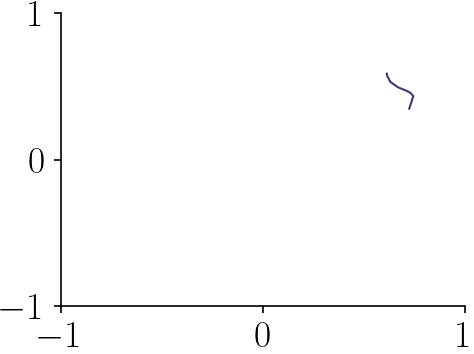

In [27]:
# Create datatset maker
dm = SimpleDatasetMaker()

# Generate dataset
r, v = dm.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

Train model

In [28]:
loss_history = []
progress = tqdm(range(train_steps))

# Train loop
for i in progress:

    r, v = dm.generate_dataset(bs, timesteps)
    r_label = r[:, 1:]
    loss = model.train_step(x=(v, r[:, 0]), y=r_label, optimizer=optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000437: 100%|██████████| 50000/50000 [04:21<00:00, 191.56it/s]


Plot loss history

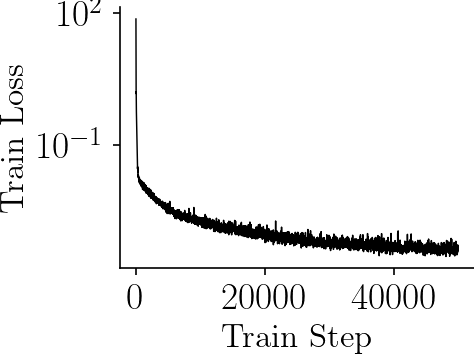

In [29]:
plt.semilogy(np.arange(len(loss_history)) * 10, loss_history, "-k", linewidth=0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")
plt.savefig('rnn_loss')
plt.show()

Plot ratemaps

In [30]:
r, v = dm.generate_dataset(5000, timesteps)
p, _ = model.spatial_representation(v, model.p0(r[:, 0])[None])
p = p.detach().numpy()

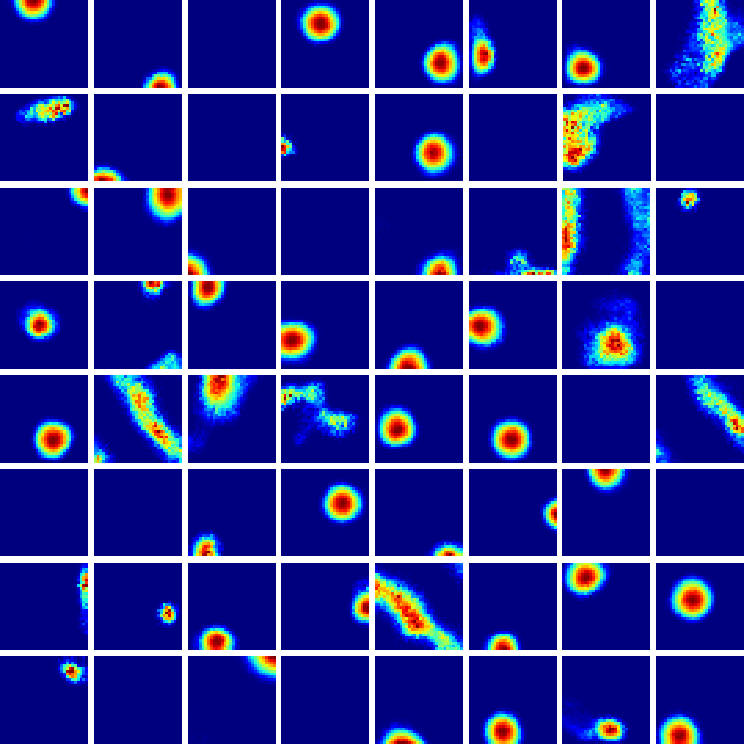

In [31]:
n_show = 8

fig, ax = plt.subplots(n_show, n_show, figsize=(5, 5), constrained_layout=True)

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1], ps.T, bins=32)

for i in range(n_show**2):
    ax[i//n_show, i%n_show].imshow(ratemaps[i].T, origin = "lower", cmap="jet")
    ax[i//n_show, i%n_show].axis("off")

In [32]:
plot_ratemaps = ratemaps[np.any(ratemaps, axis=(1, 2))]

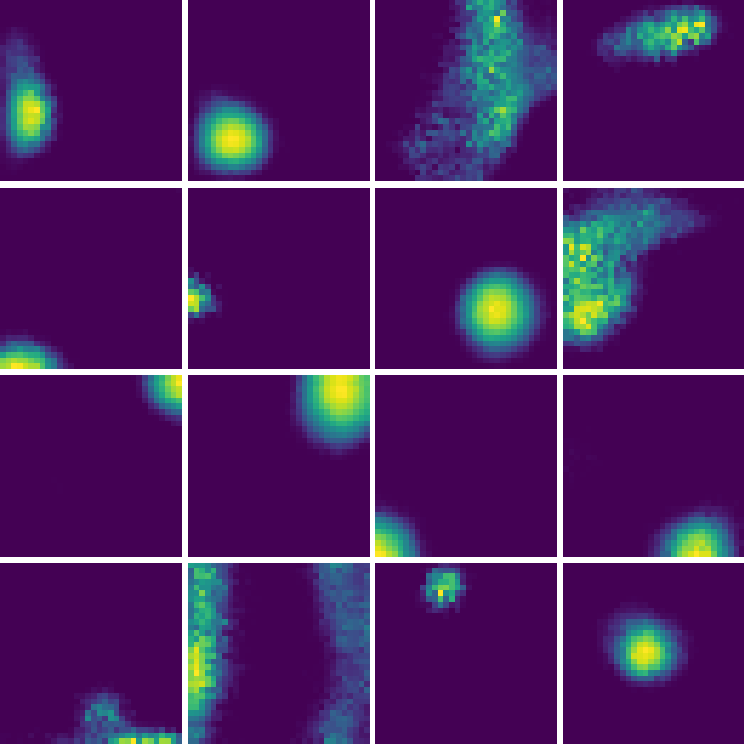

In [35]:
fig, ax = ratemap_collage(plot_ratemaps[:25])
fig.savefig('ratemaps_rnn')